In [1]:
!pip install tensorflow

import os
import datetime
import sys
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import chain

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.layers import Input, Layer, InputSpec
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D


2021-11-24 22:34:47.984524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 22:34:47.984575: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
!pip install neptune-client neptune-tensorflow-keras

from neptune.new.integrations.tensorflow_keras import NeptuneCallback

# SESSION


In [4]:
# import neptune.new as neptune

# run = neptune.init(
#     project="denissimo/UNET-X",
#     tags=['categorical_ce', 'baseline', 'additional_training'],
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYzYyNmYyMC02YmVkLTRjN2QtYmY5ZC00NDdmZDBhODMxNTIifQ==",
# )  # your credentials


# neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')

In [5]:
CFG = {
    'dataset_path': './data'
}

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
NUM_SAMPLES = 3083

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


2021-11-24 22:34:51.682207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-24 22:34:51.682253: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 22:34:51.682275: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sample): /proc/driver/nvidia/version does not exist


## 1) Uploading data

In [7]:
y = np.load(f'{CFG["dataset_path"]}/y_train.npy')
x = np.load(f'{CFG["dataset_path"]}/x_train.npy')


## 2) Common code samples

### * Metrics

In [8]:
def apply_ohe(sample, index_shape, n_classes):
    new_shape = (*index_shape, n_classes)
    responce_tensor = np.zeros(new_shape)
    for img_class in range(n_classes):
        responce_tensor[:,:,:,img_class] = (sample == img_class).reshape(index_shape)
    return responce_tensor

In [9]:
y_ohe = apply_ohe(y, (NUM_SAMPLES, IMG_HEIGHT, IMG_WIDTH), 3)

In [10]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

def IoU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_class_0(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,0])
    y_pred_f = K.flatten(y_pred[:,:,:,0])
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_class_1(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_class_2(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,2])
    y_pred_f = K.flatten(y_pred[:,:,:,2])
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [11]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[IoU, 'accuracy'])
    
    #model.summary()
    
    return model

custom_loss = weighted_categorical_crossentropy(np.array([0.0038977 , 0.08838018, 0.90772211]))

2021-11-24 22:34:59.926200: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def get_model():
    return multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

In [13]:
model = tf.keras.models.load_model('unet_tasks_binary_ce.h5', 
    custom_objects={
        'IoU': IoU,
        'IoU_class_0': IoU_class_0,
        'IoU_class_1': IoU_class_1,
        'IoU_class_2': IoU_class_2,
    })

In [14]:
import matplotlib.pyplot as plt 
pred = model.predict(x[500:800])

2021-11-24 22:35:00.714345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [15]:
pred = (pred*255).astype('uint8')

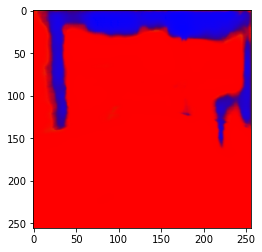

In [46]:
obj = 1
plt.imshow(pred[obj,:,:,:])

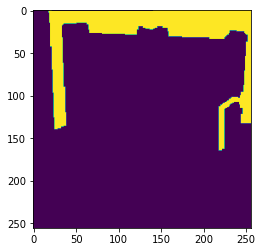

In [48]:
plt.imshow(y[obj + 500,:,:])

In [18]:
assert False

AssertionError: 

In [ ]:
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[IoU, 'accuracy', IoU_class_0, IoU_class_1, IoU_class_2])
model.summary()

In [ ]:
run['model/method'] = 'adam'
run['model/loss'] = 'categorical_crossentropy'
run['model/batchsize'] = 64
run['model/epochs'] = 100

In [ ]:
def train_model(model, X, Y, save_path, batch_size, epochs, model_name=""):
    model_name += datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    earlystopper = EarlyStopping(patience=50, verbose=1)
    checkpointer = ModelCheckpoint(save_path, verbose=1, save_best_only=False)

    log_dir = "./" + model_name

    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=1)

    results = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=batch_size, epochs=epochs, 
                      callbacks=[earlystopper, checkpointer
                                 # , neptune_cbk
                            ], workers=16)

    return results



In [ ]:
train_model(model, x, y_ohe, 'unet_tasks_baseline_prelearned.h5', 2, 6, 'fcn_new')

In [ ]:
run.stop()

In [ ]:
y_hat = model.predict(x)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
obj = 228

plt.imshow(y_ohe[obj])


In [ ]:
plt.imshow(y_hat[obj])